In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import nltk
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder 
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import re
from collections import Counter
from nltk import ngrams
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import pandas as pd
import tensorflow as tf
import numpy as np
from tabulate import tabulate
from tqdm import trange
import random
model_name = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(model_name)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceCl

In [13]:
df =pd.read_csv("bert.csv")
df

text  \
0                  effect edentulism spirometric tests   
1    multiple chronic diseases associated tooth los...   
2    knowledge attitudes practices patients healthc...   
3    asthma chronic obstructive pulmonary disease t...   
4    cohort study impact tooth loss periodontal dis...   
..                                                 ...   
121  treatment obstructive sleep apnea using adjust...   
122  management obstructive sleep apnea edentulous ...   
123  treatment obstructive sleep apnoea edentulous ...   
124                   managing obstructive sleep apnea   
125  mandibular advancement combined horizontal adv...   

                                                 text2  label  
0    impact denture wear edentulous subjects perfor...      1  
1    half us adults aged years lost least one perma...      0  
2    poor oral health associated worse clinical out...      0  
3    adults chronic respiratory conditions specific...      0  
4    copd patients fatal nonfatal respiratoryrelate...      0  
..                                                 ...    ...  
121  paper reports case oral appliance used treatme...      0  
122  literature treatment obstructive sleep apnea e...      1  
123  report describes fabrication prosthesis preven...      1  
124  obstructive sleep apnea cessation breathing sl...      1  
125  orthognathic surgical procedures used past tre...      1  

[126 rows x 3 columns]

In [14]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) 
    text = re.sub(r'\s+', ' ', text)  
    return text.strip()

# to make sure the data is in the right dtypes
df['text'] = df['text'].apply(preprocess_text)
df['text2'] = df['text2'].apply(preprocess_text)

print(df.dtypes)

text     object
text2    object
label     int64
dtype: object


In [15]:
X = df[['text', 'text2']] 
y = df['label']  

#label encoder
label_encoder = LabelEncoder()
X['text'] = label_encoder.fit_transform(X['text'])
X['text2'] = label_encoder.fit_transform(X['text2'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (100, 2) (100,)
Test set shape: (26, 2) (26,)


C:\Users\User\AppData\Local\Temp\ipykernel_27884\3158477982.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text'] = label_encoder.fit_transform(X['text'])
C:\Users\User\AppData\Local\Temp\ipykernel_27884\3158477982.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text2'] = label_encoder.fit_transform(X['text2'])


In [16]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch

class CustomDataset(Dataset):
    def __init__(self, texts, text2s, labels):
        self.texts = texts
        self.text2s = text2s
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        text = self.texts[index]
        text2 = self.text2s[index]
        label = self.labels[index]
        return text, text2, label


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

#tokenize and put into tensors
def tokenize_function(texts, text2s):
    inputs = tokenizer.batch_encode_plus(
        list(zip(texts, text2s)),
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return inputs

train_texts = df['text'].tolist()
train_text2s = df['text2'].tolist()
train_labels = df['label'].tolist()

train_texts = [str(text) for text in train_texts]
train_text2s = [str(text2) for text2 in train_text2s]

train_dataset = CustomDataset(train_texts, train_text2s, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

early_stopping_epochs = 4
best_loss = float('inf')
best_model = None
epochs_without_improvement = 0

model.train()
for epoch in range(6):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for step, batch in enumerate(train_dataloader):
        texts, text2s, labels = batch

        inputs = tokenize_function(texts, text2s)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)

        loss.backward()
        optimizer.step()

        if (step + 1) % 100 == 0:
            accuracy = correct_predictions / total_predictions
            avg_loss = total_loss / (step + 1)
            print(f'Step {step + 1} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1} - Average Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

    # check if validation loss has improved
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # stop training if there have been no improvements for each epochs
    if epochs_without_improvement >= early_stopping_epochs:
        print(f'Early stopping. No improvement in {early_stopping_epochs} epochs.')
        break


torch.save(best_model, 'best_model')
tokenizer.save_pretrained('tokenizer')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1 - Average Loss: 0.5771 - Accuracy: 0.7143


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 2 - Average Loss: 0.3304 - Accuracy: 0.8968


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 3 - Average Loss: 0.3143 - Accuracy: 0.8968


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 4 - Average Loss: 0.2605 - Accuracy: 0.8968


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 5 - Average Loss: 0.2147 - Accuracy: 0.9286


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 6 - Average Loss: 0.1188 - Accuracy: 0.9762


('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\vocab.txt',
 'tokenizer\\added_tokens.json')

In [17]:
from sklearn.metrics import classification_report

model.eval()
y_true = []
y_pred = []

for step, batch in enumerate(train_dataloader):
    texts, text2s, labels = batch

    inputs = tokenize_function(texts, text2s)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits

    _, predicted_labels = torch.max(logits, dim=1)

    y_true.extend(labels.detach().cpu().numpy())
    y_pred.extend(predicted_labels.detach().cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred)
print(report)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       113
           1       1.00      0.85      0.92        13

    accuracy                           0.98       126
   macro avg       0.99      0.92      0.95       126
weighted avg       0.98      0.98      0.98       126



Text(50.722222222222214, 0.5, 'Truth')

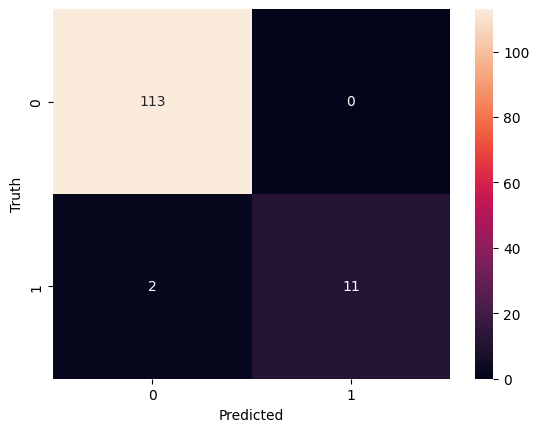

In [18]:
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')